In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import requests
from shapely.geometry import Point
from matplotlib import pyplot as plt
%matplotlib inline
import time # NB: Use to limit rate of making requests to a website
print('Libraries loaded.')

Libraries loaded.


In [2]:
#get list of all obstacle names
with open("data/06-CA-noheader.Dat",'r') as f:
    lines = f.readlines()
trunc_lines = [s[35:] for s in lines]
with open("data/CA-obstacles.Dat",'w') as f:
    f.writelines(trunc_lines)

In [17]:
df = pd.read_table("data/CA-obstacles.Dat", sep="\s+",
                   usecols=range(7),
                   header=None)
df.columns = ['lat_deg','lat_min','lat_sec','lon_deg','lon_min','lon_sec','name']

In [18]:
#list all obstacle names
df['name'].unique()

array(['TOWER', 'UTILITY', 'POLE', 'T-L', 'BLDG', 'STACK', 'ANTENNA',
       'SOLAR', 'SIGN', 'ELEC', 'BLDG-TWR', 'CATENARY', 'VERTICAL',
       'TANK', 'FENCE', 'CRANE', 'BRIDGE', 'WINDMILL', 'MONUMENT',
       'SPIRE', 'CTRL', 'NAVAID', 'MET', 'AMUSEMENT', 'GEN', 'ELEVATOR',
       'LANDFILL', 'BALLOON', 'DOME', 'PLANT', 'HEAT', 'DAM', 'REFINERY',
       'WINDSOCK', 'RIG', 'SILO', 'STADIUM', 'AG', 'COOL'], dtype=object)

according to the FAA website, 'catenary' means 'the highest point in sag above ground' of power lines
wouldn't that be the location of the transmission structures?

In [19]:
def to_dec_coords(sign,degree,minute,second):
        return sign*(degree + minute/60 + second/(60*60))
def convert_obstacle_df(df):
    for c, cs in zip(['lat_sec','lon_sec'],['lat_sign','lon_sign']):
        #convert cardinal direction to decimal degree sign
        #for north america these will be the same for all rows (N,W)
        df[cs] = df[c].apply(lambda s: 
                            {'N' : 1, 'S' : -1, 'E' : 1, 'W' : -1}[s[-1]]
                            )
        #drop N, W markers
        df[c] = df[c].apply(lambda s: s[:-1])

    #convert to float
    for c in df.columns:
        df[c] = df[c].astype(np.float)

    df['latitude'] = to_dec_coords(df['lat_sign'],df['lat_deg'],df['lat_min'],df['lat_sec'])
    df['longitude'] = to_dec_coords(df['lon_sign'],df['lon_deg'],df['lon_min'],df['lon_sec'])
    return df[['latitude','longitude']]



df_cat = df[df.name == 'CATENARY'].reset_index()
df_cat = df_cat.drop(['name'],axis=1)
df_cat = convert_obstacle_df(df_cat)

df_cat

,latitude,longitude
0,32.607408,-116.780339
1,32.613714,-116.266311
2,32.627903,-116.185831
3,32.628139,-116.183131
4,32.632814,-117.019833
...,...,...
1086,41.115556,-121.751111
1087,41.180556,-121.674444
1088,41.235556,-121.631667
1089,41.985833,-122.373333


## plot points on CA map

In [30]:
usa_gpd = gpd.read_file('maps/states_21basic/states.shp')
ca_gpd = usa_gpd[usa_gpd.STATE_ABBR == 'CA']
df_cat['points'] =  [Point(xy) for xy in zip(df_cat['longitude'],df_cat['latitude'])]
crs = usa_gpd.crs
cat_gdf = gpd.GeoDataFrame(df_cat, crs = crs, geometry = df_cat['points'])

(33, 34)

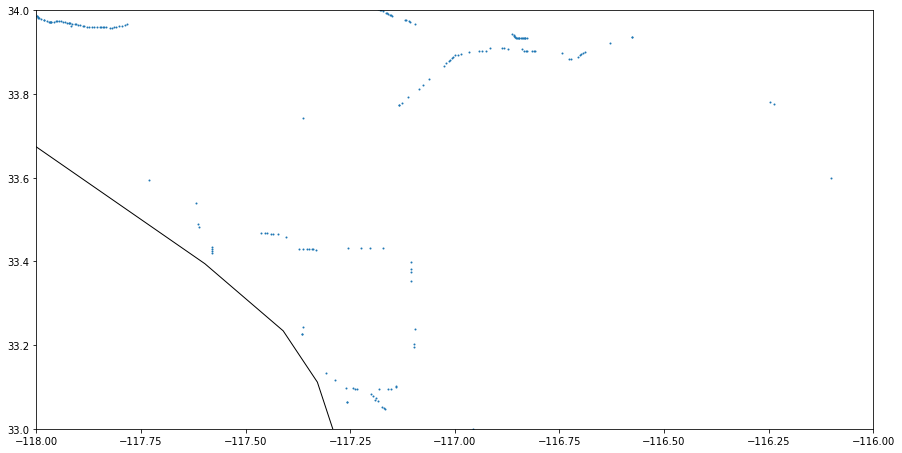

In [34]:
fig, ax = plt.subplots(figsize=(15,8))
#plot california
base = ca_gpd.plot(color='white',edgecolor='black',ax=ax)
#plot cat locations
cat_gdf.plot(ax=ax,markersize=1)
ax.set_xlim(-118,-116)
ax.set_ylim(33,34)

## plot points on google map

In [5]:
import os
import gmaps
import geopandas as gpd
gmaps.configure(api_key=os.environ["GOOGLE_API_KEY"])

In [26]:
locations = earthquake_df[['latitude', 'longitude']]
weights = earthquake_df['magnitude']
cat_layer = gmaps.symbol_layer(
    df_cat, fill_color="red", stroke_color="red", scale=2
)

In [29]:
# fig = gmaps.figure(map_type='SATELLITE')
# fig.add_layer(cat_layer)
# fig


In [12]:
trans_json

{'type': 'FeatureCollection',
 'name': 'dec7ab27-ad57-4f32-aa75-b2bed63639ae202048-1-uxy61v.2x6jc',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'type': 'Feature',
   'properties': {'OBJECTID': 1,
    'Name': 'AMP 115kV',
    'kV': '115',
    'kV_Sort': 115.0,
    'Owner': 'AMP',
    'Status': 'Operational',
    'Circuit': 'Single',
    'Type': 'OH',
    'Legend': 'Other_110_161kV',
    'Length_Mile': 1,
    'Length_Feet': '6135.61557739',
    'Comments': 'Partially underwater',
    'Shape__Length': 2368.33799123094},
   'geometry': {'type': 'LineString',
    'coordinates': [[-122.28884212182, 37.7887063270256],
     [-122.288645606368, 37.7887025538175],
     [-122.288681679117, 37.7898092988359],
     [-122.288573250665, 37.7899542146943],
     [-122.286675278455, 37.7901832914051],
     [-122.285826245646, 37.7901709220603],
     [-122.284792785115, 37.7901799200774],
     [-122.2837505184, 37.7901962187312],
     [-122.28264981

In [11]:
from shapely.geometry import shape
for d in trans_json:
    d['the_geom'] = shape(d['the_geom'])

gdf = gpd.GeoDataFrame(data).set_geometry('the_geom')

TypeError: string indices must be integers

In [4]:
#geojson
r = requests.get('https://opendata.arcgis.com/datasets/a5b51de6cb3b47c794021c4358fad97e_0.geojson')
trans_json = r.json()
trans_layer = gmaps.geojson_layer(trans_json)

In [18]:
r = requests.get('https://opendata.arcgis.com/datasets/a5b51de6cb3b47c794021c4358fad97e_0.json')

In [22]:
#shape file
trans_gdf = gpd.read_file('data/ca-transmission-lines/c1ba3265-9d1d-4aa2-88d2-d8e27e2d9e76202048-1-1beav9v.4src.shx')

In [41]:
trans_gdf['length'] = pd.to_numeric(trans_gdf['Length_Fee'])

In [51]:
trans_gdf.head()

,OBJECTID,Name,kV,kV_Sort,Owner,Status,Circuit,Type,Legend,Length_Mil,Length_Fee,Comments,Shape__Len,geometry,length
0,1,AMP 115kV,115,115.0,AMP,Operational,Single,OH,Other_110_161kV,1.0,6135.61557739,Partially underwater,2368.337991,"LINESTRING (-122.28884 37.78871, -122.28865 37...",6135.615577
1,2,ANZA 34kV,34,34.0,ANZA,Operational,Single,OH,Other_33_92kV,24.0,127189.40561552,None,46585.778208,"LINESTRING (-116.73115 33.70480, -116.73104 33...",127189.405616
2,3,APUD 69kV,69,69.0,APUD,Operational,Single,UG,Other_33_92kV,2.0,8059.98812038,None,2966.499916,"LINESTRING (-117.97226 33.83716, -117.97228 33...",8059.988120
3,4,APUD 69kV,69,69.0,APUD,Operational,Double,OH,Other_33_92kV,3.0,17482.19329398,None,6415.017460,"LINESTRING (-117.96778 33.83774, -117.96765 33...",17482.193294
4,5,APUD 69kV,69,69.0,APUD,Operational,Double,UG,Other_33_92kV,0.0,1626.83346215,None,598.915102,"LINESTRING (-117.92361 33.84682, -117.92375 33...",1626.833462


In [45]:
trans_valid_gdf = trans_gdf[['kV_Sort','length','geometry']].dropna()


In [52]:
np.max(trans_valid_gdf['length'])

1551754.22707837

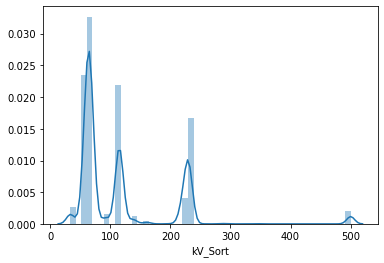

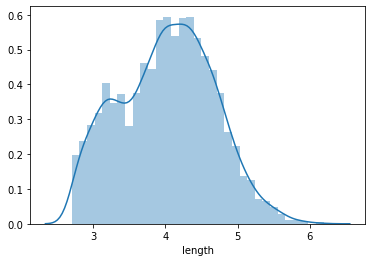

In [55]:
import seaborn as sns
sns.distplot(trans_valid_gdf['kV_Sort']); plt.show()
sns.distplot(np.log10(trans_valid_gdf['length'][trans_valid_gdf['length'] > 500]));plt.show()

In [74]:
trans_long_gdf = trans_valid_gdf[trans_valid_gdf['length'] > 5000]
print(len(trans_long_gdf))

4174


In [69]:
trans_long_gdf.to_file("trans_long.geojson", driver='GeoJSON')

In [3]:
import json
with open('trans_long.geojson','r') as f : 
    trans_long_geojson = json.load(f)

In [11]:
trans_layer = gmaps.geojson_layer(trans_long_geojson,stroke_color=(255,0,255))

In [5]:
usa_turbines = pd.read_csv('data/uswtdbCSV/uswtdb_v3_0_1_20200514.csv')
ca_turbines = usa_turbines[usa_turbines.t_state == 'CA']
ca_turbines = ca_turbines.rename(columns={"xlong" : "longitude", "ylat" : "latitude"})

In [63]:
#count number of turbines at each plant
ca_turbines[['p_name','t_state']].groupby(['p_name']).count().sort_values('t_state',ascending=False).head(10)

,t_state
p_name,
unknown Tehachapi Wind Resource Area 1,772
Mesa Wind Farm,432
Sky River,327
"Mojave 16, 17 & 18 (Desertwind III PPC Tru",288
Ridgetop,228
Painted Hills,223
Historic Victory Garden (Wind Stream),217
Tehachapi Windplant II,202
Difwind 6,199


In [75]:
turbine_layer = gmaps.symbol_layer(
    ca_turbines[ca_turbines.p_name == '251 Wind'][['latitude','longitude']],
    fill_color="red", stroke_color="red", scale=2)

Many of  251 Wind turbines unaccounted for

Most / all of Dinosaur point turbines accounted for

In [12]:
fig = gmaps.figure(
    layout={
        'width': '800px',
        'height': '600px',
    },
    map_type='SATELLITE')
fig.add_layer(trans_layer)
#fig.add_layer(turbine_layer)
fig

Figure(layout=FigureLayout(height='600px', width='800px'))